In [3]:
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import List
from langchain.schema import Document
from langchain_huggingface  import HuggingFaceEmbeddings
from qdrant_client import QdrantClient
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_groq import ChatGroq
from huggingface_hub import InferenceClient
from datasets import load_dataset
import tqdm as notebook_tqdm
from langchain_qdrant import Qdrant
import time
import evaluate
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import warnings
import numpy as np
import os

In [2]:
qdrant_url = os.environ["qdrant_url"]
qdrant_api_key = os.environ["qdrant_api_key"]
GROQ_API_KEY = os.environ["GROQ_API_KEY"]
HF_TOKEN = os.environ["HF_TOKEN"]

In [4]:
#Extract Data From the PDF File
def load_pdf_file(data):
    loader= DirectoryLoader(data,
                            glob="*.pdf",
                            loader_cls=PyPDFLoader)

    documents=loader.load()

    return documents


In [5]:
extracted_data=load_pdf_file(data='data/')

In [6]:
def filter_to_minimal_docs(docs: List[Document]) -> List[Document]:
    """
    Given a list of Document objects, return a new list of Document objects
    containing only 'source' in metadata and the original page_content.
    """
    minimal_docs: List[Document] = []
    for doc in docs:
        src = doc.metadata.get("source")
        minimal_docs.append(
            Document(
                page_content=doc.page_content,
                metadata={"source": src}
            )
        )
    return minimal_docs

In [7]:
minimal_docs = filter_to_minimal_docs(extracted_data)

In [8]:
#Split the Data into Text Chunks
def text_split(minimal_docs):
    text_splitter=RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
    text_chunks=text_splitter.split_documents(minimal_docs)
    return text_chunks

In [9]:
text_chunks=text_split(minimal_docs)
print("Length of Text Chunks", len(text_chunks))

Length of Text Chunks 5859


In [10]:
#Download the Embeddings from Hugging Face
def download_hugging_face_embeddings():
    embeddings=HuggingFaceEmbeddings(model_name='NeuML/pubmedbert-base-embeddings')
    return embeddings

embeddings = download_hugging_face_embeddings()

In [11]:
# Initialise Qdrant Client

qdrant_client = QdrantClient(
    url=qdrant_url, 
    api_key=qdrant_api_key,
)

print(qdrant_client.get_collections())

# Configuration
collection_name = "vectordb"
embedding_dim = 768

# Check if collection exists
if not qdrant_client.collection_exists(collection_name):
    qdrant_client.recreate_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(
            size=embedding_dim,
            distance=models.Distance.COSINE
        )
    )
    print(f"Collection '{collection_name}' created.")
else:
    print(f"Collection '{collection_name}' already exists.")



collections=[CollectionDescription(name='vectordb')]
Collection 'vectordb' already exists.


In [18]:
# Adding documents to vector db

# Initialize LangChain Qdrant vectorstore
qdrant = Qdrant(
    client=qdrant_client,
    collection_name=collection_name,
    embeddings=embeddings
)

# Add documents
# qdrant.add_documents(text_chunks)
# print("Documents added to the Qdrant collection.")

C:\Users\dhivs\AppData\Local\Temp\ipykernel_15252\854922642.py:4: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.1.2 and will be removed in 0.5.0. Use :class:`~QdrantVectorStore` instead.
  qdrant = Qdrant(


In [19]:
# Searching through Vector db
query = "What is Acne ?"

# Perform similarity search to retrieve top 3 candidates
results = qdrant.similarity_search(query, k=3)

# Display the results
print("Top candidates for query:")
for idx, doc in enumerate(results, 1):
    print(f"\nCandidate {idx}:\n{doc.page_content}")

Top candidates for query:

Candidate 1:
good lighting, the doctor determines what types and how
many blemishes are present, whether they are inflamed,
whether they are deep or superficial, and whether there is
scarring or skin discoloration.
In teenagers, acne is often found on the forehead,
nose, and chin. As people get older, acne tends to appear
towards the outer part of the face. Adult women may
have acne on their chins and around their mouths. The
elderly may develop whiteheads and blackheads on the

Candidate 2:
5.
Bergfeld, Wilma F. “The Evaluation and Management of Acne:
Economic Considerations.” Journal of the American
Academy of Dermatology 32 (1995): S52-6.
Billings, Laura. “Getting Clear.”Health Magazine, Apr. 1997,
48-52.
Christiano, Donna. “Acne Treatment Meant for Grown- Ups.”
American Health (Oct. 1994): 23-4.
“Clearly Better New Treatments Help Adult Acne.”Prevention
Magazine, Aug. 1997, 50-51.
Leyden, James J. “Therapy For Acne Vulgaris.”New England

Candidate 3:
depe

In [22]:

# Initialise retriever from qdrant
retriever = qdrant.as_retriever(search_kwargs={"k": 3})

# --- 1. Prompt Template ---
def build_prompt(context: str, question: str) -> str:
    prompt_template = PromptTemplate(
        input_variables=["context", "question"],
        template="""
You are a knowledgeable medical assistant AI. Use the following context to answer the question strictly based on the provided information.

Context:
{context}

Question:
{question}

Guidelines:
- Be concise and accurate.
- If the context lacks an answer, reply: "I'm sorry, but the provided context does not contain relevant information."
Answer:
"""
    )
    return prompt_template.format(context=context, question=question)


# --- 2. LLaMA Model-based RAG ---
def query_llama_rag(question: str, retriever):
    llm = ChatGroq(
        groq_api_key=GROQ_API_KEY,
        model_name="llama3-70b-8192"
    )

    prompt = PromptTemplate(
        input_variables=["context", "question"],
        template="""
You are **Medical chatbot**, an AI-powered assistant trained to help users understand medical documents and health-related questions.

Your job is to provide clear, accurate, and helpful responses based **only on the provided context**.

---

**Context**:
{context}

**User Question**:
{question}

---

**Answer**:
- Respond in a calm, factual, and respectful tone.
- Use simple explanations when needed.
- If the context does not contain the answer, say: "I'm sorry, but I couldn't find relevant information in the provided documents."
- Do NOT make up facts.
- Do NOT give medical advice or diagnoses.
"""
    )

    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        chain_type_kwargs={"prompt": prompt},
        return_source_documents=True
    )

    result = qa_chain.invoke(question)
    return result['result'], result['source_documents']


# --- 3. MedGemma-based RAG ---
client = InferenceClient(
    provider="featherless-ai",
    api_key=HF_TOKEN
)

def generate_medgemma_response(prompt: str) -> str:
    completion = client.chat.completions.create(
        model="google/medgemma-4b-it",
        messages=[
            {
                "role": "user",
                "content": [{"type": "text", "text": prompt}]
            }
        ],
    )
    return completion.choices[0].message['content']

def query_medgemma_rag(question: str, retriever):
    docs = retriever.invoke(question)
    context = "\n".join(doc.page_content for doc in docs)

    prompt = build_prompt(context, question)
    answer = generate_medgemma_response(prompt)

    return answer, docs


# --- 4. Example Usage ---
def display_results(answer, source_docs):
    print("Answer:", answer)
    print("\nSources:")
    for doc in source_docs:
        print("-", doc.page_content)


# Example query
query = "What is Acid phosphatase test"

# Qdrant retriever (assumed to be initialized already)
# retriever = qdrant.as_retriever(search_kwargs={"k": 3})

# LLaMA RAG
llama_answer, llama_docs = query_llama_rag(query, retriever)
print("\n===== LLaMA RAG Response =====")
display_results(llama_answer, llama_docs)

# MedGemma RAG
medgemma_answer, medgemma_docs = query_medgemma_rag(query, retriever)
print("\n===== MedGemma RAG Response =====")
display_results(medgemma_answer, medgemma_docs)



===== LLaMA RAG Response =====
Answer: The Acid Phosphatase test is a laboratory test that measures the amount of acid phosphatase, an enzyme, in a person's blood. It's primarily used to diagnose whether prostate cancer has spread to other parts of the body (metastasized) and to check the effectiveness of treatment.

Sources:
- Description
Laboratory testing measures the amount of acid
phosphatase in a person’s blood, and can determine from
what tissue the enzyme is coming. For example, it is
important to know if the increased acid phosphatase is
from the prostate or red blood cells. Acid phosphatase
from the prostate, called prostatic acid phosphatase
(PAP), is the most medically significant type of acid
phosphatase.
KEY TERMS
Enzyme—A substance needed to trigger specific
chemical reactions.
- Achromatopsia see Color blindness
Acid indigestion see Heartburn
Acid phosphatase test
Definition
Acid phosphatase is an enzyme found throughout
the body, but primarily in the prostate gland. L

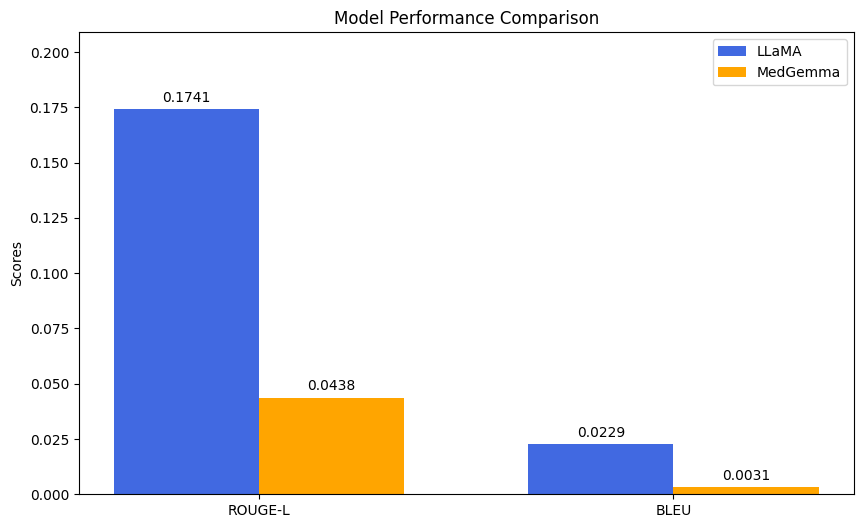

Latency of LLAMA: 1.5066 sec
Latency of MEDGEMMA: 3.2822 sec


In [46]:

# suppress BLEU warnings
warnings.filterwarnings("ignore", category=UserWarning, module='nltk.translate.bleu_score')

# --- Load Dataset ---
dataset = load_dataset("pubmed_qa", "pqa_artificial")['train']

# --- Evaluation Metrics ---
rouge = Rouge()
smoother = SmoothingFunction().method1

def evaluate_models_on_dataset(dataset, retriever, sample_size=100):
    metrics = {
        "llama": {"rouge": [], "bleu": [], "latency": []},
        "medgemma": {"rouge": [], "bleu": [], "latency": []}
    }

    for example in dataset.select(range(sample_size)):
        question = example['question']
        reference = example['long_answer']  # Ground truth

        # --- LLaMA Evaluation ---
        start = time.time()
        llama_output = query_llama_rag(question, retriever)
        llama_latency = time.time() - start
        llama_answer = llama_output['result'] if isinstance(llama_output, dict) else llama_output[0]

        # --- MedGemma Evaluation ---
        start = time.time()
        medgemma_output = query_medgemma_rag(question, retriever)
        medgemma_latency = time.time() - start
        medgemma_answer = medgemma_output['result'] if isinstance(medgemma_output, dict) else medgemma_output[0]

        # --- Scoring ---
        for model_name, answer, latency in [
            ("llama", llama_answer, llama_latency),
            ("medgemma", medgemma_answer, medgemma_latency)
        ]:
            try:
                rouge_score = rouge.get_scores(answer, reference)[0]['rouge-l']['f']
                bleu_score = sentence_bleu([reference.split()], answer.split(), smoothing_function=smoother)
            except Exception as e:
                print(f"Scoring error for {model_name}: {e}")
                rouge_score, bleu_score = 0, 0

            metrics[model_name]["rouge"].append(rouge_score)
            metrics[model_name]["bleu"].append(bleu_score)
            metrics[model_name]["latency"].append(latency)

    return metrics

results = evaluate_models_on_dataset(dataset, retriever, sample_size=10)

# Compute averages
metrics_names = ['ROUGE-L', 'BLEU']
llama_avgs = [
    sum(results['llama']['rouge']) / len(results['llama']['rouge']),
    sum(results['llama']['bleu']) / len(results['llama']['bleu']),
]

medgemma_avgs = [
    sum(results['medgemma']['rouge']) / len(results['medgemma']['rouge']),
    sum(results['medgemma']['bleu']) / len(results['medgemma']['bleu']),
]

# Visualization
x = np.arange(len(metrics_names))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, llama_avgs, width, label='LLaMA', color='royalblue')
bars2 = ax.bar(x + width/2, medgemma_avgs, width, label='MedGemma', color='orange')

# Labels and title
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

# Display values on top of bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.ylim(0, max(max(llama_avgs), max(medgemma_avgs)) * 1.2)
plt.show()

print(f"Latency of LLAMA: {sum(results['llama']['latency']) / len(results['llama']['latency']):.4f} sec")
print(f"Latency of MEDGEMMA: {sum(results['medgemma']['latency']) / len(results['medgemma']['latency']):.4f} sec")
